In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torchvision.models import resnet18
from PIL import Image

# Dataset Class
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []
        for cls in self.classes:
            cls_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_path):
                self.image_paths.append(os.path.join(cls_path, img_name))
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            if isinstance(self.transform, list):
                view1 = self.transform[0](image)
                view2 = self.transform[1](image)
                return view1, view2
            else:
                image = self.transform(image)
                return image, label
        return image, label

# Data Transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Datasets
train_dataset = BrainTumorDataset(root_dir='/kaggle/input/brain-tumor-mri-dataset/Training', transform=[train_transform, train_transform])
test_dataset = BrainTumorDataset(root_dir='/kaggle/input/brain-tumor-mri-dataset/Testing', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# SimCLR Model
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim=128, lr=1e-3, num_classes=4):
        super(SimCLR, self).__init__()
        self.encoder = resnet18(pretrained=False)
        self.encoder.fc = nn.Identity()
        self.projection = nn.Sequential(
            nn.Linear(512, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.classifier = nn.Linear(512, num_classes)  # Linear classifier for evaluation
        self.lr = lr
        self.num_classes = num_classes

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection(h)
        return F.normalize(z, dim=1)

    def training_step(self, batch, batch_idx):
        view1, view2 = batch
        x = torch.cat([view1, view2], dim=0)
        z = self(x)
        n_samples = z.shape[0] // 2
        z1, z2 = z[:n_samples], z[n_samples:]
        sim_matrix = torch.matmul(z1, z2.T)
        sim_matrix = sim_matrix / 0.07
        labels = torch.arange(n_samples).to(self.device)
        loss = F.cross_entropy(sim_matrix, labels)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def extract_features(self, x):
        """Extract features from the encoder."""
        with torch.no_grad():
            h = self.encoder(x)
        return h

    def evaluate(self, test_loader):
        """Evaluate the model by training a linear classifier on the test set."""
        self.eval()
        features = []
        labels = []
        for batch in test_loader:
            x, y = batch
            x = x.to(self.device)
            h = self.extract_features(x)
            features.append(h.cpu())
            labels.append(y)
        features = torch.cat(features, dim=0)
        labels = torch.cat(labels, dim=0)

        # Train a linear classifier
        classifier = nn.Linear(512, self.num_classes).to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

        # Create a dataset and dataloader for the features
        dataset = TensorDataset(features, labels)
        loader = DataLoader(dataset, batch_size=32, shuffle=True)

        # Train the classifier
        for epoch in range(10):  # Train for 10 epochs
            for batch in loader:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                outputs = classifier(x)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()

        # Evaluate the classifier
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in loader:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)
                outputs = classifier(x)
                _, predicted = torch.max(outputs.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")
        return accuracy

# Initialize Model and Trainer
model = SimCLR()
trainer = Trainer(max_epochs=10, accelerator='gpu' if torch.cuda.is_available() else 'cpu', devices=1)

# Step 1: Train the SimCLR model
trainer.fit(model, train_loader)

# Step 2: Evaluate the trained model on the test set
accuracy = model.evaluate(test_loader)
print(f"Final Test Accuracy: {accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training: |          | 0/? [00:00<?, ?it/s]

Test Accuracy: 76.74%
Final Test Accuracy: 76.74%


In [4]:
torch.save(model.state_dict(), 'simclr_brain_tumor.pt')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-5-73ee0e0e33d4>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Predicted Class: pituitary


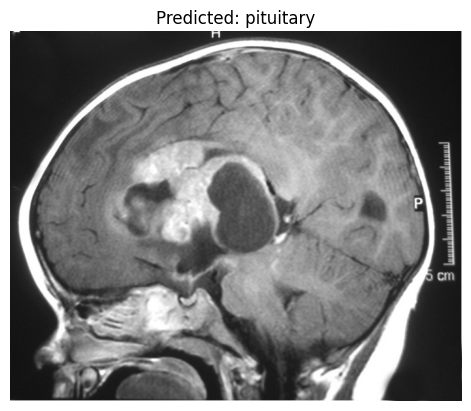

In [5]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size of the model
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load an image from the internet or local file
image_path = "/kaggle/input/test-tumor/image.jpg"  # Replace with the path to your image
image = Image.open(image_path).convert('RGB')  # Open and convert to RGB

# Preprocess the image
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

# Load the trained model
model = SimCLR()
model.load_state_dict(torch.load('simclr_brain_tumor.pt'))
model.eval()  # Set the model to evaluation mode

# Move the input to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_batch = input_batch.to(device)
model = model.to(device)

# Extract features
with torch.no_grad():
    features = model.extract_features(input_batch)

# Use the classifier to get predictions
classifier = nn.Linear(512, 4).to(device)  # Replace 512 with the feature size and 4 with the number of classes
classifier.load_state_dict(model.classifier.state_dict())  # Load the trained classifier weights
outputs = classifier(features)

# Get the predicted class
_, predicted_class = torch.max(outputs, 1)
predicted_class = predicted_class.item()

# Define class names (replace with your actual class names)
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

# Get the predicted class name
predicted_class_name = class_names[predicted_class]
print(f"Predicted Class: {predicted_class_name}")

# Display the image
plt.imshow(image)
plt.title(f"Predicted: {predicted_class_name}")
plt.axis('off')
plt.show()